# Compare aligned audio segments
Compare music similarity between similar structural segments by hierarchically decomposing structure and finding segment alignment

Code from https://github.com/bmcfee/lsd_viz/blob/main/segmenter.py



## > Library importing

In [60]:
#Computation
import numpy as np
import scipy
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import cv2

#Data Processing
import sklearn.cluster

#Audio
import librosa
from librosa import display

#System
import glob
import os
import sys

#Pickling
import dill

## > Loading audio

In [61]:
#Choose directory containing audiofiles
directory = '../Datasets/smc'

In [62]:
#Read all paths in specified directory
all_dirs = []
all_names= []
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name) or ('.mp3' in name)):
                filepath = os.path.join(root, name)
                all_dirs.append(filepath)
                all_names.append(name[:-4])
file_no = len(all_names)
#Load all audiofiles and store in array
all_audio = []
for f in range(file_no):
    y, sr = librosa.load(all_dirs[f], sr=22050, mono=True)
    all_audio.append((y, sr))
    sys.stdout.write("\rLoaded %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 1/3 pieces./Users/chris/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 2/3 pieces./Users/chris/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 3/3 pieces.

## > Compute Laplacian

In [ ]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
all_CQT_sync = []
all_L = []
all_beat_times = []

for i in range(file_no):
    y, sr = librosa.load(all_dirs[i])
   
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                            ref=np.max)
    
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    all_beat_times.append(librosa.frames_to_time(librosa.util.fix_frames(beats, x_min=0, x_max=C.shape[1]), sr=sr))

    Csync = librosa.util.sync(C, beats, aggregate=np.median)
    all_CQT_sync.append(Csync)

    Cstack = librosa.feature.stack_memory(Csync, 4)
    
    R = librosa.segment.recurrence_matrix(Cstack, width=3, mode='affinity', sym=True)

    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    Rf = librosa.segment.path_enhance(Rf, 15)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)

    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)

    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)

    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

    A = mu * Rf + (1 - mu) * R_path
    
    L = scipy.sparse.csgraph.laplacian(A, normed=True)
    all_L.append(L)
    sys.stdout.write("\rLoaded %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()

In [65]:
fig, ax = plt.subplots(nrows=file_no, ncols=1, figsize=(10,5*file_no))
for i in range(file_no):
    librosa.display.specshow(all_CQT_sync[i], ax=ax[i], y_axis='hz', x_axis='s', cmap='magma')
    ax[i].set(title=all_names[i] + ' - Chroma Beat-Synced - '+str(all_CQT_sync[i].shape))

Error in callback <function flush_figures at 0x11d86c8b0> (for post_execute):


KeyboardInterrupt: 

## > Compute Laplacian approximations and clusters

In [52]:
all_sets = []
all_seg_ids = []
for f in range(file_no):
    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(all_L[f])
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    dist_set = []
    seg_ids_set = []
    kmin = 2; kmax = 10; #change eigenvector number here
    for k in range(kmin, kmax):
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]
        distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
        dist_set.append(distance)
        KM = sklearn.cluster.KMeans(n_clusters=k, n_init=50, max_iter=500)
        seg_ids = KM.fit_predict(Xs)
        seg_ids_set.append(seg_ids)
    all_seg_ids.append(seg_ids_set)
    all_sets.append(dist_set)
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()


Computed for 2/2 pieces.

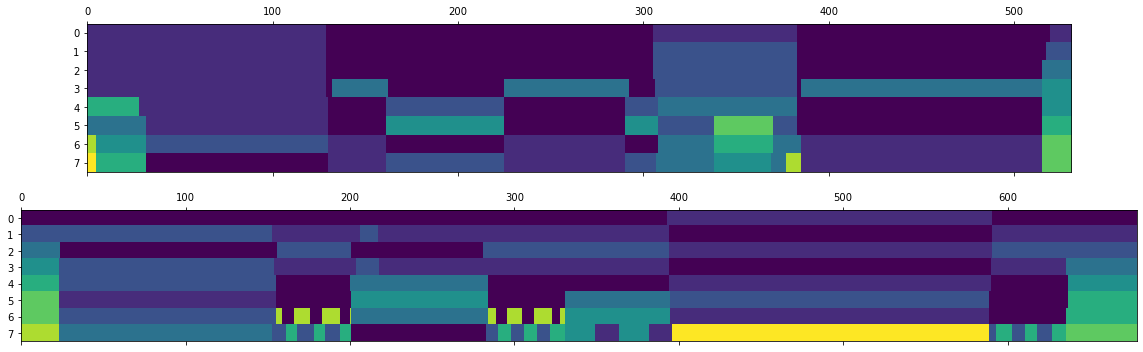

In [53]:
fig, axs = plt.subplots(file_no, 1, figsize=(20, 3*file_no))
for j in range(file_no):
    axs[j].matshow(all_seg_ids[j], aspect=10)
    ax[j].set(title=all_names[j])
plt.show()

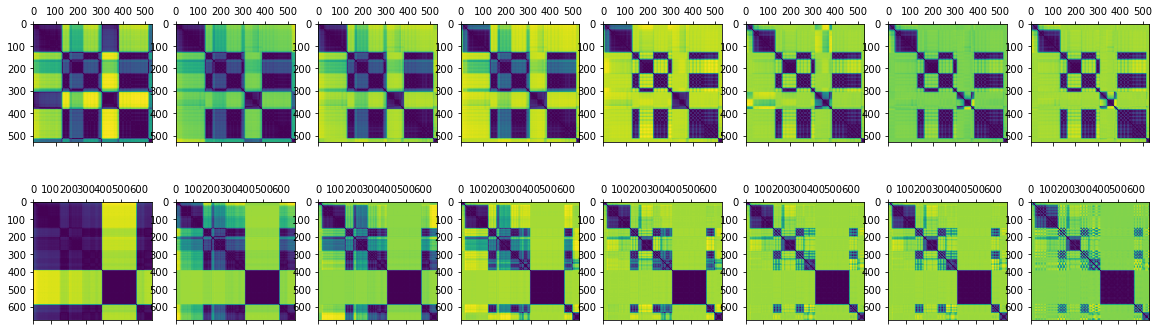

In [54]:
fig, axs = plt.subplots(file_no, kmax-kmin, figsize=(20, 3*file_no))
for j in range(file_no):
    for i in range(kmax-kmin):
        axs[j,i].matshow(all_sets[j][i])
plt.show()

## > Format segments and boundaries

In [55]:
all_formatted_beats = []
all_formatted_times = []
all_formatted_frames = []

#traverse files
for f in range(file_no):
    all_formatted_beats.append([])
    all_formatted_times.append([])
    all_formatted_frames.append([])
    #traverse hierarchies
    for i in range(kmax-kmin):
        all_formatted_beats[f].append([])
        all_formatted_times[f].append([])
        all_formatted_frames[f].append([])
        # Locate segment boundaries from the label sequence
        bound_beats = 1 + np.flatnonzero(all_seg_ids[f][i][:-1] != all_seg_ids[f][i][1:])
        # Count beats 0 as a boundary
        bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)
        
        # Convert beat indices to frames
        bound_times = all_beat_times[f][bound_beats]
        # Tack on the end-time
        bound_times = list(np.append(bound_times, all_beat_times[f][-1]))

        # format as [beat_start_position, segment_length_in_beats]
        beat_poslen = []
        # format as [time_start_position, segment_length_in_time]
        time_poslen = []

        #traverse beats
        for idx in range(len(bound_beats)-1):
            beat_poslen.append([ bound_beats[idx], bound_beats[idx+1]-bound_beats[idx] ])
            time_poslen.append([ bound_times[idx], bound_times[idx+1]-bound_times[idx] ])

        all_formatted_beats[f][i] = beat_poslen
        all_formatted_times[f][i] = time_poslen
        all_formatted_frames[f][i] = librosa.time_to_frames(time_poslen,hop_length=1)

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 2/2 pieces.

## > Find segment hits

In [56]:
s1 = 0 #index of song 1
s2 = 1 #index of song 2

In [57]:
hits = []
#traverse hierarchies, song 1
for i in range(kmax-kmin):
    #traverse segments, song 1
    for j in range(len(all_formatted_beats[s1][i])):
        #traverse hierarchies, song 2
        for k in range(kmax-kmin):
            #traverse segments, song 2
            for l in range(len(all_formatted_beats[s2][k])):
                if all_formatted_beats[s1][i][j][1] == all_formatted_beats[s2][k][l][1]:
                    hits.append([i,j,k,l])
print(hits)


[[0, 1, 3, 4], [1, 1, 3, 4], [2, 1, 3, 4], [2, 3, 2, 1], [2, 3, 4, 1], [2, 3, 5, 1], [2, 3, 6, 1], [3, 1, 6, 16], [3, 5, 3, 3], [3, 5, 7, 18], [3, 8, 7, 1], [4, 3, 5, 5], [4, 3, 6, 17], [4, 5, 7, 15], [4, 5, 7, 17], [4, 7, 2, 1], [4, 7, 4, 1], [4, 7, 5, 1], [4, 7, 6, 1], [5, 3, 5, 5], [5, 3, 6, 17], [5, 5, 7, 15], [5, 5, 7, 17], [5, 9, 2, 1], [5, 9, 4, 1], [5, 9, 5, 1], [5, 9, 6, 1], [6, 0, 6, 10], [6, 0, 6, 15], [6, 4, 5, 5], [6, 4, 6, 17], [6, 6, 7, 15], [6, 6, 7, 17], [6, 9, 7, 16], [6, 10, 7, 1], [7, 0, 6, 10], [7, 0, 6, 15], [7, 4, 5, 5], [7, 4, 6, 17], [7, 9, 7, 2], [7, 9, 7, 10], [7, 9, 7, 11], [7, 9, 7, 12], [7, 9, 7, 13], [7, 9, 7, 22], [7, 10, 7, 2], [7, 10, 7, 10], [7, 10, 7, 11], [7, 10, 7, 12], [7, 10, 7, 13], [7, 10, 7, 22], [7, 11, 7, 1]]


### > Choose index of two songs you want to compare

## > See what part of the audio is being compared

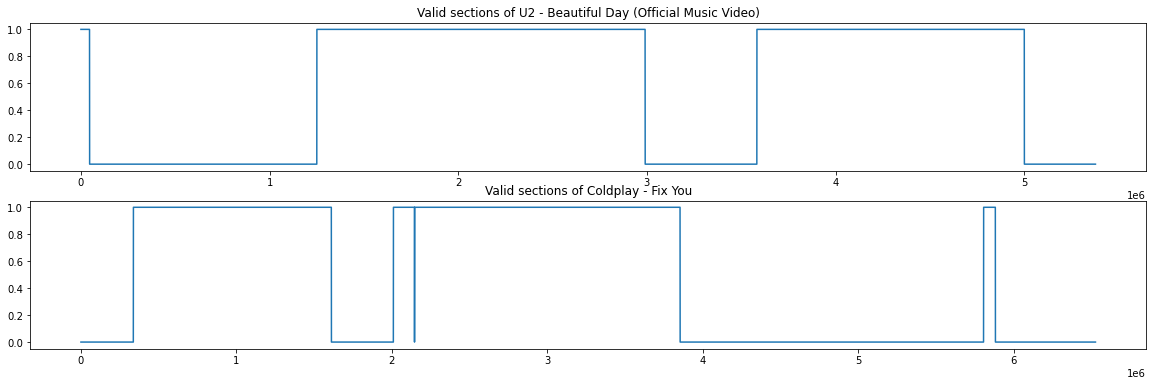

In [58]:
# Create an array of size equal to the song samples
valid1 = np.zeros(len(all_audio[s1][0]))
valid2 = np.zeros(len(all_audio[s2][0]))

for hit in hits:
    # get start and end time from hit interval
    
    start, end = (all_formatted_frames[s1][hit[0]][hit[1]][0], all_formatted_frames[s1][hit[0]][hit[1]][0] + all_formatted_frames[s1][hit[0]][hit[1]][1])
    valid1[start:end] = 1

    start, end = (all_formatted_frames[s2][hit[2]][hit[3]][0], all_formatted_frames[s2][hit[2]][hit[3]][0] + all_formatted_frames[s2][hit[2]][hit[3]][1])
    valid2[start:end] = 1

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
axs[0].plot(valid1)
axs[0].set(title='Valid sections of ' + all_names[s1])
axs[1].plot(valid2)
axs[1].set(title='Valid sections of ' + all_names[s2])

plt.show()

## > See all audio segments that can be compared

[Text(0.5, 1.0, 'Valid sections of second song')]

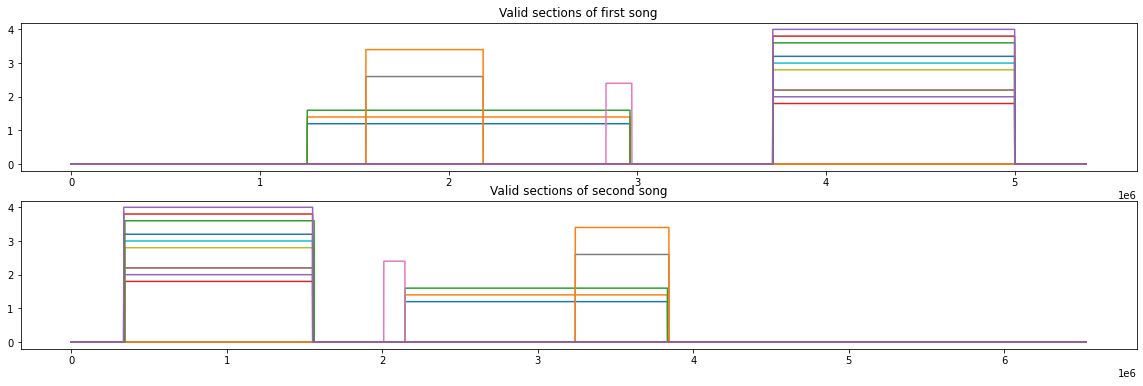

In [47]:
sections1 = []
sections2 = []

iter = 0
for hit in hits:

    iter+=1
    start, end = (all_formatted_frames[s1][hit[0]][hit[1]][0], all_formatted_frames[s1][hit[0]][hit[1]][0] + all_formatted_frames[s1][hit[0]][hit[1]][1])

    space = np.zeros(len(all_audio[s1][0]))
    space[start:end] = 1 + iter*0.2
    sections1.append(space)

    start, end = (all_formatted_frames[s2][hit[2]][hit[3]][0], all_formatted_frames[s2][hit[2]][hit[3]][0] + all_formatted_frames[s2][hit[2]][hit[3]][1])

    space = np.zeros(len(all_audio[s2][0]))
    space[start:end] = 1 + iter*0.2
    sections2.append(space)

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
for interval in sections1:
    axs[0].plot(interval)
axs[0].set(title='Valid sections of ' + all_names[s1])
for interval in sections2:
    axs[1].plot(interval)
axs[1].set(title='Valid sections of ' + all_names[s2])

## > See all audio segments that can be compared, with no repetitions

[Text(0.5, 1.0, 'Valid sections of second song')]

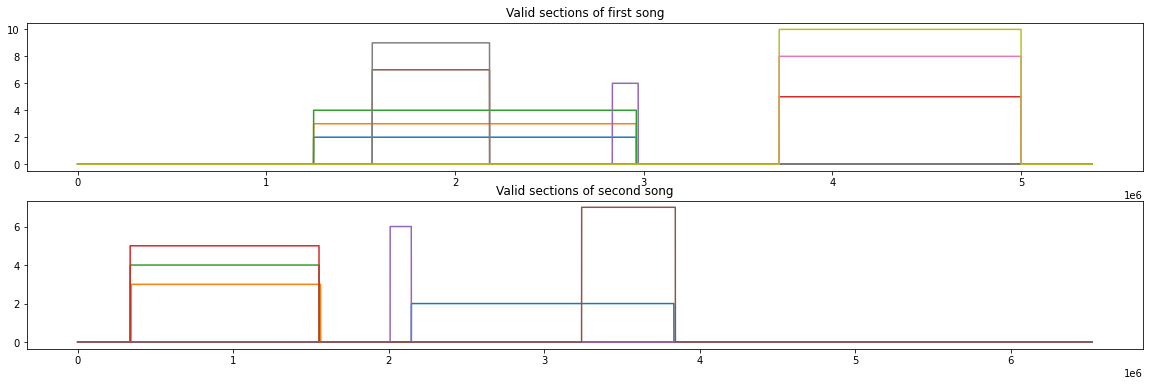

In [48]:
sections1 = []
sections2 = []
intervals1 = []
intervals2 = []

iter1 = 0
iter2 = 0
for hit in hits:

    #check if interval already added
    if [hit[0],hit[1]] not in intervals1:
        iter1+=1
        #if not, then add
        intervals1.append([hit[0], hit[1]])
        start, end = (all_formatted_frames[s1][hit[0]][hit[1]][0], all_formatted_frames[s1][hit[0]][hit[1]][0] + all_formatted_frames[s1][hit[0]][hit[1]][1])

        space = np.zeros(len(all_audio[s1][0]))
        space[start:end] = 1 + iter1
        sections1.append(space)

    #do the same for the second song
    if [hit[2], hit[3]] not in intervals2:
        iter2+=1
        intervals2.append([hit[2], hit[3]])
        start, end = (all_formatted_frames[s2][hit[2]][hit[3]][0], all_formatted_frames[s2][hit[2]][hit[3]][0] + all_formatted_frames[s2][hit[2]][hit[3]][1])

        space = np.zeros(len(all_audio[s2][0]))
        space[start:end] = 1 + iter2
        sections2.append(space)

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
for interval in sections1:
    axs[0].plot(interval)
axs[0].set(title='Valid sections of ' + all_names[s1])
for interval in sections2:
    axs[1].plot(interval)
axs[1].set(title='Valid sections of ' + all_names[s2])

## > Plot segments against beats, no repetitions

[Text(0.5, 1.0, 'Valid sections of second song')]

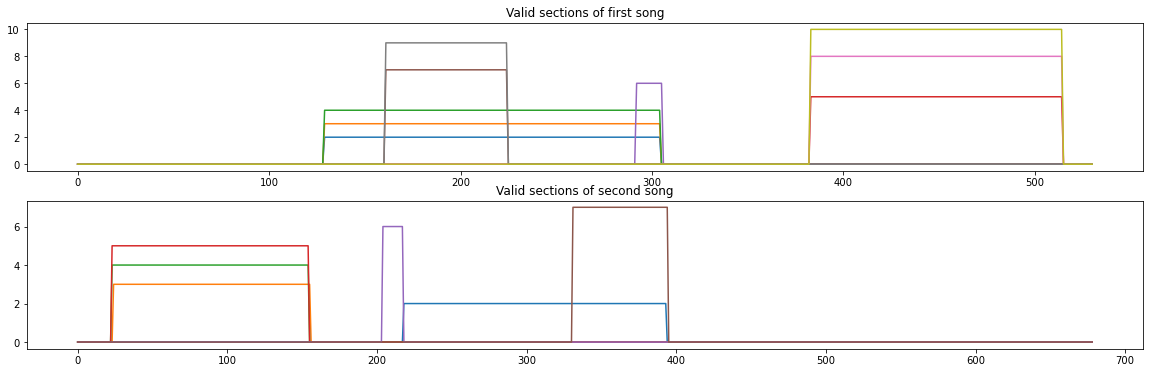

In [49]:
sections1 = []
sections2 = []
intervals1 = []
intervals2 = []

iter1 = 0
iter2 = 0
for hit in hits:

    #check if interval already added
    if [hit[0],hit[1]] not in intervals1:
        iter1+=1
        #if not, then add
        intervals1.append([hit[0], hit[1]])
        start, end = (all_formatted_beats[s1][hit[0]][hit[1]][0], all_formatted_beats[s1][hit[0]][hit[1]][0] + all_formatted_beats[s1][hit[0]][hit[1]][1])

        space = np.zeros(len(all_CQT_sync[s1][0]))
        space[start:end] = 1 + iter1
        sections1.append(space)

    #do the same for the second song
    if [hit[2], hit[3]] not in intervals2:
        iter2+=1
        intervals2.append([hit[2], hit[3]])
        start, end = (all_formatted_beats[s2][hit[2]][hit[3]][0], all_formatted_beats[s2][hit[2]][hit[3]][0] + all_formatted_beats[s2][hit[2]][hit[3]][1])

        space = np.zeros(len(all_CQT_sync[s2][0]))
        space[start:end] = 1 + iter2
        sections2.append(space)

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
for interval in sections1:
    axs[0].plot(interval)
axs[0].set(title='Valid sections of ' + all_names[s1])
for interval in sections2:
    axs[1].plot(interval)
axs[1].set(title='Valid sections of ' + all_names[s2])

## > Plot segments against beats, no overlaps

[Text(0.5, 1.0, 'Valid sections of Coldplay - Fix You')]

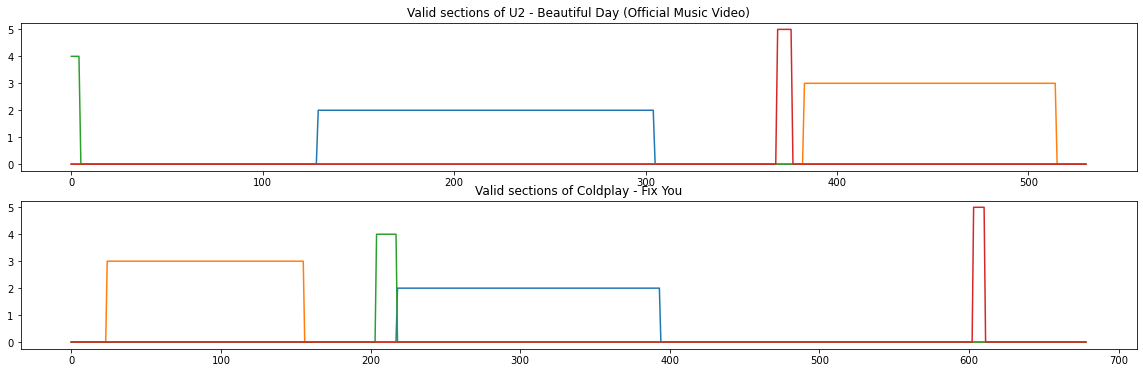

In [59]:
sections1 = []
sections2 = []
aggregate1 = np.zeros(len(all_CQT_sync[s1][0]))
aggregate2 = np.zeros(len(all_CQT_sync[s2][0]))

iter1 = 0
iter2 = 0
for hit in hits:

    start, end = (all_formatted_beats[s1][hit[0]][hit[1]][0], all_formatted_beats[s1][hit[0]][hit[1]][0] + all_formatted_beats[s1][hit[0]][hit[1]][1])

    #if aggregate entries are 0 (avoid overlapping)
    if not np.any(aggregate1[start:end]):
        iter1+=1
        #then make them 1
        aggregate1[start:end] = 1
        #and add interval to be plotted
        space = np.zeros(len(all_CQT_sync[s1][0]))
        space[start:end] = 1 + iter1
        sections1.append(space)

    start, end = (all_formatted_beats[s2][hit[2]][hit[3]][0], all_formatted_beats[s2][hit[2]][hit[3]][0] + all_formatted_beats[s2][hit[2]][hit[3]][1])
    if not np.any(aggregate2[start:end]):
        iter2+=1
        aggregate2[start:end] = 1
        space = np.zeros(len(all_CQT_sync[s2][0]))
        space[start:end] = 1 + iter2
        sections2.append(space)

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
for interval in sections1:
    axs[0].plot(interval)
axs[0].set(title='Valid sections of ' + all_names[s1])
for interval in sections2:
    axs[1].plot(interval)
axs[1].set(title='Valid sections of ' + all_names[s2])